In [39]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
%matplotlib inline

labeled_images = pd.read_csv('train.csv')
images = labeled_images.iloc[:,1:]
labels = labeled_images.iloc[:,:1]

In [555]:


#non linear function and der
def relu(x):
    return np.maximum(0,x)

def relu_dev(x):
    return (x>0)*1

def softmax(x):
    A = np.exp(x)
    s = np.sum(A, axis = 1).reshape((A.shape[0], 1))
    A = (A / s) + 1e-15
    return A

def softmax_dev(x):
    return (1-x)*x

def log_loss(A,Y):
     return (-np.trace(np.dot(Y, np.log(A).T)) / Y.shape[0])
    
def log_loss_dev(A,Y):
    return (-(Y/A)+(1-Y)/(1-A))
#-----------------------start here:--------------------------
def create_matrix(X, num_layers):
#This function caculation A_out with linear,non linear function
    W_all=[]
    b_all=[]
    
    W = np.random.rand(X.shape[1],num_layers[0])*0.001
    b = np.random.rand(1,num_layers[0])*0.001
    W_all.append(W)
    b_all.append(b)
    for i in range(np.size(num_layers)-1):
        W = np.random.rand(num_layers[i],num_layers[i+1])*0.001
        b = np.random.rand(1,num_layers[i+1])*0.001
        W_all.append(W)
        b_all.append(b)
    
    
    return W_all,b_all

    
def forward(A_past, W, b, catches, activ_func):
#This function caculation A_out with linear,non linear function
    Z = np.dot(A_past,W) + b
    catches.append(A_past)
    catches.append(Z)
    if activ_func=="relu" :
        A=relu(Z)
        
    if activ_func=="softmax" :  
        A = softmax(Z)
    return A,catches

def backward(da_forward, W, b, catches,Layer,active_func,lamda,m):
   

    A_past=catches[2*Layer]
    #m=A_past.shape[0]
    Z_L=catches[2*Layer+1]
    if active_func=="relu" :
        dev_func=relu_dev(Z_L)
    if active_func=="softmax" : 
        dev_func=softmax_dev(softmax(Z_L))
        
            
    dZ = da_forward*dev_func
    
    dW = (np.dot(A_past.T,dZ)+lamda*np.sum(np.absolute(W)))/m
    db = np.sum(dZ, axis = 0) /m
    
    dA_now=np.dot(dZ,W.T)
    
    return dW, db, dA_now

def forward_propogation(A_prev, W, b, type_layers):
    catches=[]

    for i in range(np.size(type_layers)):
        W_now=W[i]
        b_now=b[i]
        [A_prev,catches] = forward(A_prev, W_now, b_now,catches,type_layers[i]) 
    return A_prev,catches

def backword_propogation(Y, A, W, b, type_layers,loss_func,catches,learning_rate,lamda):
    dW_all=[]
    db_all=[]
    m=Y.shape[0]
    if loss_func=="Logloss":
        da=log_loss_dev(A,Y)   
    for i in range(np.size(type_layers),0,-1):
        [dW, db, da]=backward(da, W[i-1], b[i-1],catches,i-1,type_layers[i-1],lamda,m)
        #print(np.sum(dz-(A-Y)))
        W[i-1]=W[i-1]-learning_rate*dW
        b[i-1]=b[i-1]-learning_rate*db
    
    return W,b

def update(X,Y, W, b, type_layers,A,loss_func,catches,learning_rate,lamda):
    [A,catches]=forward_propogation(X, W, b, type_layers)
    J=log_loss(A,Y)
    regularization=0
    for i in range(np.size(type_layers),0,-1):
        regularization+=np.sum((np.absolute(W[i-1])**2))
    
    regularization=(lamda*regularization)/(2*X.shape[0])
    
    
    J=J+regularization
    [W,b]=backword_propogation(Y, A, W, b, type_layers,loss_func,catches,learning_rate,lamda)
    
    return W, b, J


def predict(X, W, b, type_layers):
    A = forward_propogation(X, W, b, type_layers)
    return np.argmax(A, axis = 1)

0.9997333333333334


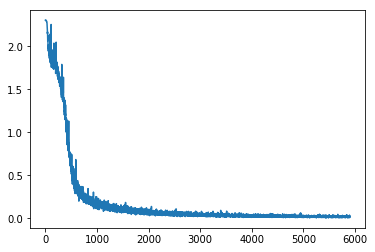

In [573]:

m = 30000
learning_rate = 0.4
minibatch_size = 512
iters = 50
lamda=0
keep_prob=0.75

X = images.values[:m, :]/256.


Y = np.zeros((m, 10), dtype = np.int32)
for i in range(m):
    Y[i, labels.values[i, :]] = 1


loss_func="Logloss"    
number_layers=[800,300,10]
type_layers=["relu","relu","softmax"]
[W,b]=create_matrix(X, number_layers)
J_all=[]
for epoch in range(iters):
    order = np.random.permutation(m)
    epoch_score = 0
    d3=np.random.rand(X.shape[0],X.shape[1])<keep_prob
    X_reduced=np.multiply(X,d3)
    X_reduced=X_reduced/keep_prob
    for i in range(0, m, minibatch_size):
        
        [W, b, J]=update(X_reduced[order[i : i + minibatch_size],:],Y[order[i : i + minibatch_size],:],\
                         W, b, type_layers,A,loss_func,catches,(0.99**epoch)*learning_rate,lamda)
        J_all.append(J)
    
plt.plot(J_all)
[A,catches]=forward_propogation(X, W, b, type_layers)
print(np.sum(np.argmax(A, axis = 1) == labels.values[:m, :].reshape((m, ))) / m)


In [574]:
X = images.values[m:, :] / 256.
m_new=X.shape[0]
[A,catches]=forward_propogation(X, W, b, type_layers)
print((1-np.sum(np.argmax(A, axis = 1) == labels.values[m:, :].reshape((m_new, ))) / m_new)*100)

1.924999999999999


In [529]:
print((0.999**25)*0.5)

0.4876488562985233
